In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.model_selection import KFold

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gzip

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

'mps'

In [2]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_val_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')

word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_val_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')

word2vec_selftrain_train_data = pd.read_csv('../Data/TrainingData/word2vec_selftrain_train.csv')
word2vec_selftrain_val_data = pd.read_csv('../Data/ValidateData/word2vec_selftrain_val.csv')

bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_val_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

bert_selftrain_train_data = pd.read_csv('../Data/TrainingData/bert_selftrain_train.csv')
bert_selftrain_val_data = pd.read_csv('../Data/ValidateData/bert_selftrain_val.csv')

In [3]:
def train_mlp_model_with_f2_score(train_df, val_df, model_path, scaler_path):
    train_data = train_df.copy()
    val_data = val_df.copy()
    
    y_train = train_data.pop('source')  # 假設標籤列名為 'source'
    y_val = val_data.pop('source')  # 假設標籤列名為 'source'

    # 標準化數據
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data.values)
    X_val_scaled = scaler.transform(val_data.values)
    
    # 保存標準化器
    with gzip.open(scaler_path, 'wb') as f:
        joblib.dump(scaler, f)

    # 10折交叉驗證
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold = 0
    confusion_matrices = []
    f2_scores = []
    best_model = None
    best_f2_score = float('-inf')

    for train_index, test_index in kf.split(X_train_scaled):
        fold += 1
        X_train, X_test = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # 將數據轉換為 PyTorch 張量並移動到 GPU
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32).view(-1, 1).to(device)
        y_test_tensor = torch.tensor(y_test_fold.values, dtype=torch.float32).view(-1, 1).to(device)

        # 建立 MLP 模型
        input_size = X_train_tensor.shape[1]
        model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)

        # 定義損失函數和優化器
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 訓練模型
        num_epochs = 100
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'Fold [{fold}], Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # 測試模型並計算F2 score
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test_tensor)
            y_pred_train = model(X_train_tensor)

            y_pred_train = y_pred_train.cpu().numpy()
            y_pred_test = y_pred_test.cpu().numpy()

            y_pred_train = (y_pred_train > 0.5).astype(int)
            y_pred_test = (y_pred_test > 0.5).astype(int)

            y_train_numpy = y_train_tensor.cpu().numpy()
            y_test_numpy = y_test_tensor.cpu().numpy()

            cm_train = confusion_matrix(y_train_numpy, y_pred_train)
            cm_test = confusion_matrix(y_test_numpy, y_pred_test)
            confusion_matrices.append((cm_train, cm_test))

            f2 = fbeta_score(y_test_numpy, y_pred_test, beta=2)
            f2_scores.append(f2)

            # 保存最佳模型
            if f2 > best_f2_score:
                best_f2_score = f2
                best_model = model

    # 計算平均F2-score
    avg_f2_score = sum(f2_scores) / len(f2_scores)
    print(f'Average F2 Score: {avg_f2_score:.4f}')

    # 計算混淆矩陣加總再標準化
    sum_cm_train = sum([cm[0] for cm in confusion_matrices])
    sum_cm_test = sum([cm[1] for cm in confusion_matrices])

    norm_cm_train = sum_cm_train.astype('float') / sum_cm_train.sum(axis=1)[:, np.newaxis]
    norm_cm_test = sum_cm_test.astype('float') / sum_cm_test.sum(axis=1)[:, np.newaxis]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Normalized Confusion Matrices')

    sns.heatmap(norm_cm_train, annot=True, fmt='.2f', ax=axs[0], cmap='Blues')
    axs[0].set_title('Normalized Train Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    sns.heatmap(norm_cm_test, annot=True, fmt='.2f', ax=axs[1], cmap='Blues')
    axs[1].set_title('Normalized Test Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

    # 保存最佳模型
    torch.save(best_model, model_path)

    # 評估validation set
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

    best_model.eval()
    with torch.no_grad():
        y_val_pred = best_model(X_val_tensor)
        y_val_pred = y_val_pred.cpu().numpy()
        y_val_pred = (y_val_pred > 0.5).astype(int)
        y_val_numpy = y_val_tensor.cpu().numpy()

        val_cm = confusion_matrix(y_val_numpy, y_val_pred)
        val_f2_score = fbeta_score(y_val_numpy, y_val_pred, beta=2)

    print(f'Validation F2 Score: {val_f2_score:.4f}')

    norm_val_cm = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7, 5))
    sns.heatmap(norm_val_cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Normalized Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

/Users/jim/anaconda3/envs/forDeepLearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fold [1], Epoch [10/100], Loss: 30.4197
Fold [1], Epoch [20/100], Loss: 0.5600
Fold [1], Epoch [30/100], Loss: 0.2780
Fold [1], Epoch [40/100], Loss: 0.1215
Fold [1], Epoch [50/100], Loss: 0.0333
Fold [1], Epoch [60/100], Loss: 0.0061
Fold [1], Epoch [70/100], Loss: 0.0006
Fold [1], Epoch [80/100], Loss: 0.0001
Fold [1], Epoch [90/100], Loss: 0.0001
Fold [1], Epoch [100/100], Loss: 0.0000
Fold [2], Epoch [10/100], Loss: 10.2427
Fold [2], Epoch [20/100], Loss: 0.4620
Fold [2], Epoch [30/100], Loss: 0.3604
Fold [2], Epoch [40/100], Loss: 0.2846
Fold [2], Epoch [50/100], Loss: 0.1619
Fold [2], Epoch [60/100], Loss: 0.0172
Fold [2], Epoch [70/100], Loss: 0.0005
Fold [2], Epoch [80/100], Loss: 0.0000
Fold [2], Epoch [90/100], Loss: 0.0000
Fold [2], Epoch [100/100], Loss: 0.0000
Fold [3], Epoch [10/100], Loss: 0.0126
Fold [3], Epoch [20/100], Loss: 0.0000
Fold [3], Epoch [30/100], Loss: 0.0000
Fold [3], Epoch [40/100], Loss: 0.0000
Fold [3], Epoch [50/100], Loss: 0.0000
Fold [3], Epoch [60/1

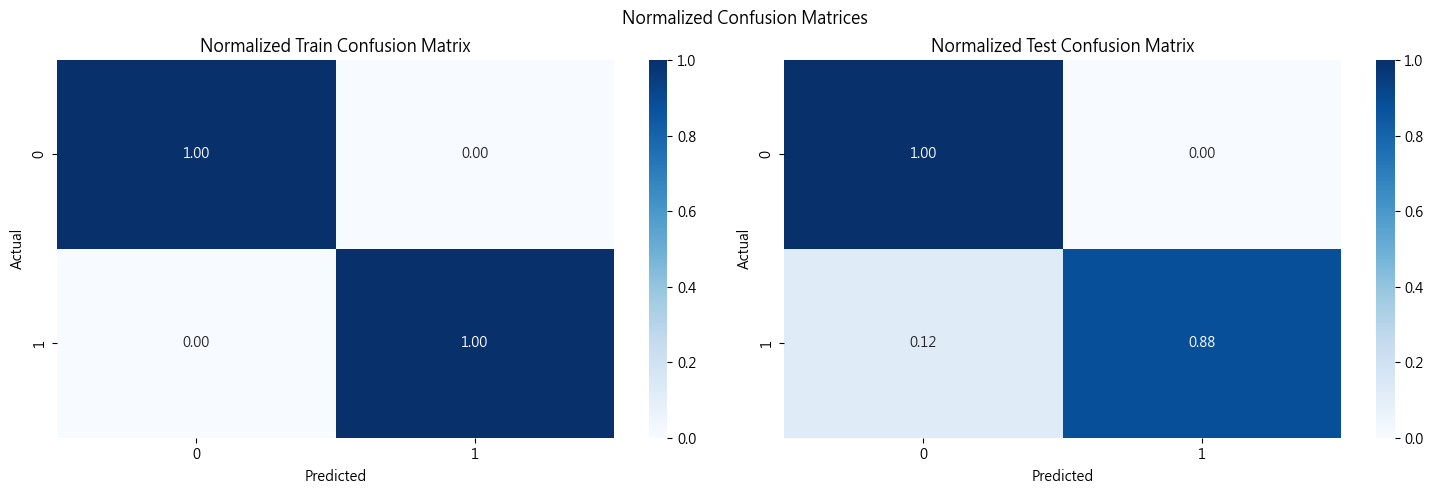

Validation F2 Score: 0.9874


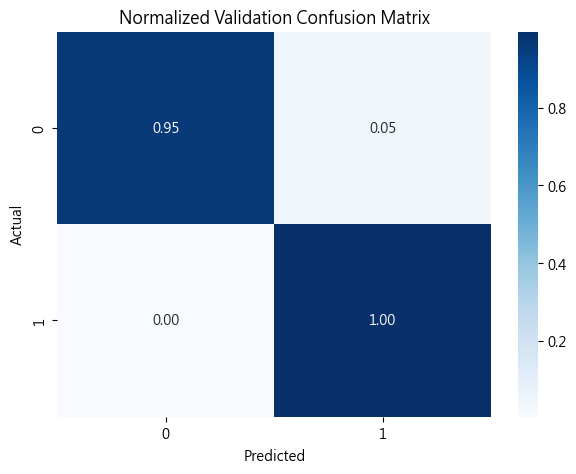

In [4]:
train_mlp_model_with_f2_score(tfidf_train_data, tfidf_val_data, '../Data/Model/tfidf_mlp_10fold_model.pth.gz', '../Data/Model/tfidf_10fold_scaler.pkl.gz')

Fold [1], Epoch [10/100], Loss: 0.0129
Fold [1], Epoch [20/100], Loss: 0.0004
Fold [1], Epoch [30/100], Loss: 0.0002
Fold [1], Epoch [40/100], Loss: 0.0000
Fold [1], Epoch [50/100], Loss: 0.0000
Fold [1], Epoch [60/100], Loss: 0.0000
Fold [1], Epoch [70/100], Loss: 0.0000
Fold [1], Epoch [80/100], Loss: 0.0000
Fold [1], Epoch [90/100], Loss: 0.0000
Fold [1], Epoch [100/100], Loss: 0.0000
Fold [2], Epoch [10/100], Loss: 0.0593
Fold [2], Epoch [20/100], Loss: 0.0184
Fold [2], Epoch [30/100], Loss: 0.1428
Fold [2], Epoch [40/100], Loss: 0.0019
Fold [2], Epoch [50/100], Loss: 0.0002
Fold [2], Epoch [60/100], Loss: 0.0001
Fold [2], Epoch [70/100], Loss: 0.0001
Fold [2], Epoch [80/100], Loss: 0.0000
Fold [2], Epoch [90/100], Loss: 0.0000
Fold [2], Epoch [100/100], Loss: 0.0000
Fold [3], Epoch [10/100], Loss: 0.0405
Fold [3], Epoch [20/100], Loss: 0.0015
Fold [3], Epoch [30/100], Loss: 0.0008
Fold [3], Epoch [40/100], Loss: 0.0000
Fold [3], Epoch [50/100], Loss: 0.0000
Fold [3], Epoch [60/100

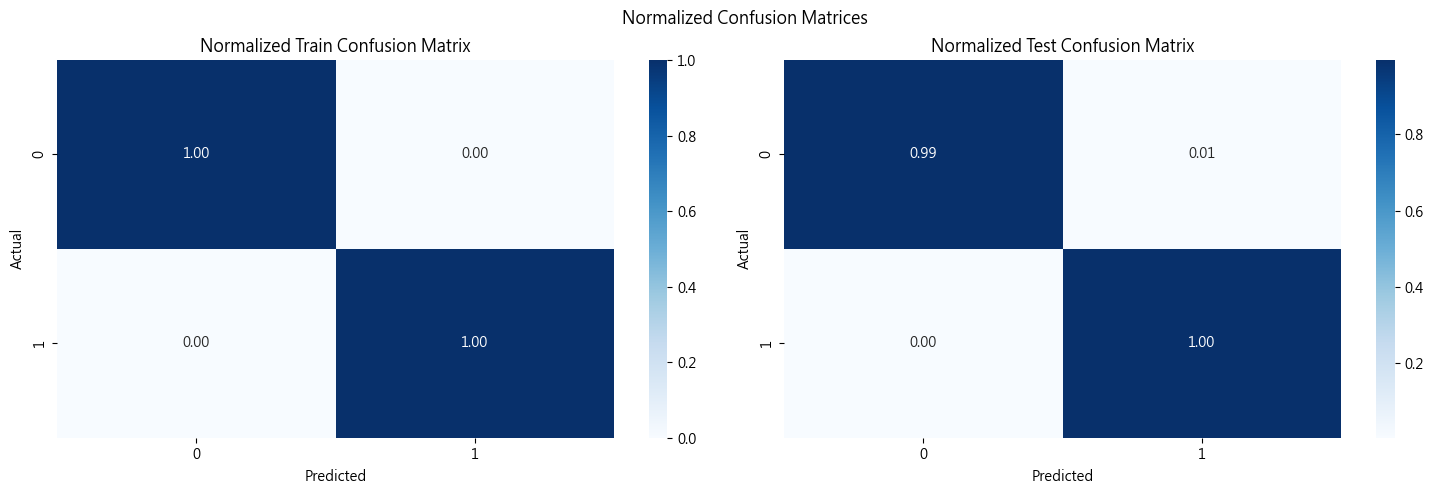

Validation F2 Score: 0.9951


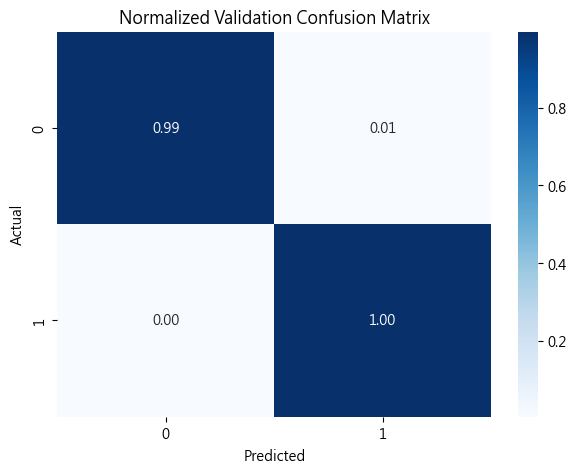

In [5]:
train_mlp_model_with_f2_score(word2vec_selftrain_train_data, word2vec_selftrain_val_data, '../Data/Model/word2vec_selftrain_mlp_10fold_model.pth.gz', '../Data/Model/word2vec_selftrain_10fold_scaler.pkl.gz')

Fold [1], Epoch [10/100], Loss: 0.0677
Fold [1], Epoch [20/100], Loss: 0.0364
Fold [1], Epoch [30/100], Loss: 0.0115
Fold [1], Epoch [40/100], Loss: 0.0016
Fold [1], Epoch [50/100], Loss: 0.0009
Fold [1], Epoch [60/100], Loss: 0.0005
Fold [1], Epoch [70/100], Loss: 0.0003
Fold [1], Epoch [80/100], Loss: 0.0003
Fold [1], Epoch [90/100], Loss: 0.0001
Fold [1], Epoch [100/100], Loss: 0.0001
Fold [2], Epoch [10/100], Loss: 0.1226
Fold [2], Epoch [20/100], Loss: 0.1358
Fold [2], Epoch [30/100], Loss: 2.1676
Fold [2], Epoch [40/100], Loss: 0.0498
Fold [2], Epoch [50/100], Loss: 0.1435
Fold [2], Epoch [60/100], Loss: 0.0433
Fold [2], Epoch [70/100], Loss: 0.0737
Fold [2], Epoch [80/100], Loss: 0.0367
Fold [2], Epoch [90/100], Loss: 0.0302
Fold [2], Epoch [100/100], Loss: 0.0215
Fold [3], Epoch [10/100], Loss: 0.0897
Fold [3], Epoch [20/100], Loss: 0.0395
Fold [3], Epoch [30/100], Loss: 0.0174
Fold [3], Epoch [40/100], Loss: 0.0076
Fold [3], Epoch [50/100], Loss: 0.0088
Fold [3], Epoch [60/100

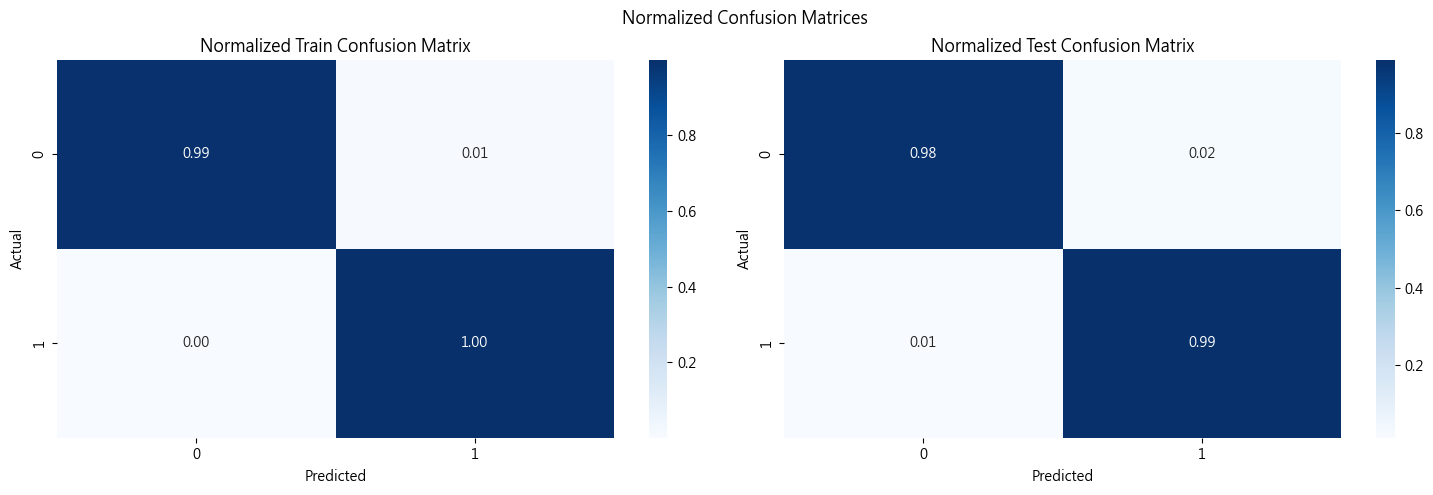

Validation F2 Score: 0.9834


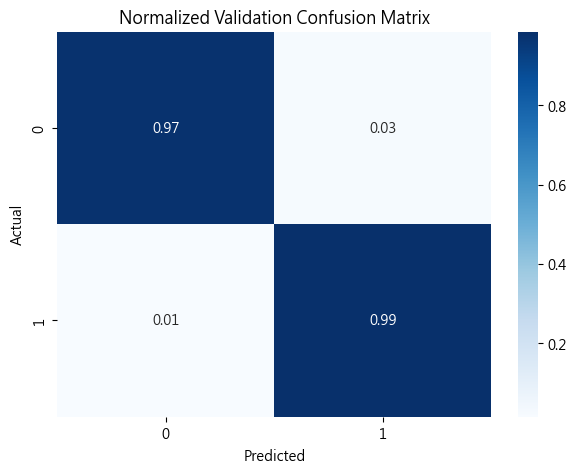

In [6]:
train_mlp_model_with_f2_score(word2vec_train_data, word2vec_val_data, '../Data/Model/word2vec_mlp_10fold_model.pth.gz', '../Data/Model/word2vec_10fold_scaler.pkl.gz')

Fold [1], Epoch [10/100], Loss: 0.0007
Fold [1], Epoch [20/100], Loss: 0.0000
Fold [1], Epoch [30/100], Loss: 0.0000
Fold [1], Epoch [40/100], Loss: 0.0000
Fold [1], Epoch [50/100], Loss: 0.0000
Fold [1], Epoch [60/100], Loss: 0.0000
Fold [1], Epoch [70/100], Loss: 0.0000
Fold [1], Epoch [80/100], Loss: 0.0000
Fold [1], Epoch [90/100], Loss: 0.0000
Fold [1], Epoch [100/100], Loss: 0.0000
Fold [2], Epoch [10/100], Loss: 0.0005
Fold [2], Epoch [20/100], Loss: 0.0000
Fold [2], Epoch [30/100], Loss: 0.0000
Fold [2], Epoch [40/100], Loss: 0.0000
Fold [2], Epoch [50/100], Loss: 0.0000
Fold [2], Epoch [60/100], Loss: 0.0000
Fold [2], Epoch [70/100], Loss: 0.0000
Fold [2], Epoch [80/100], Loss: 0.0000
Fold [2], Epoch [90/100], Loss: 0.0000
Fold [2], Epoch [100/100], Loss: 0.0000
Fold [3], Epoch [10/100], Loss: 0.0005
Fold [3], Epoch [20/100], Loss: 0.0000
Fold [3], Epoch [30/100], Loss: 0.0000
Fold [3], Epoch [40/100], Loss: 0.0000
Fold [3], Epoch [50/100], Loss: 0.0000
Fold [3], Epoch [60/100

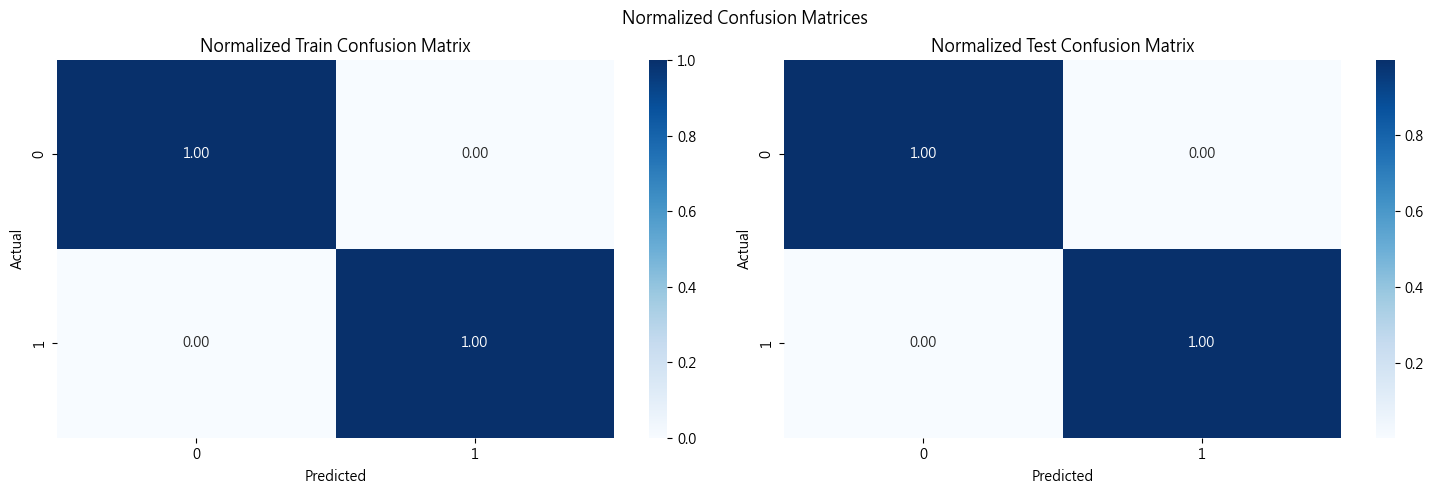

Validation F2 Score: 1.0000


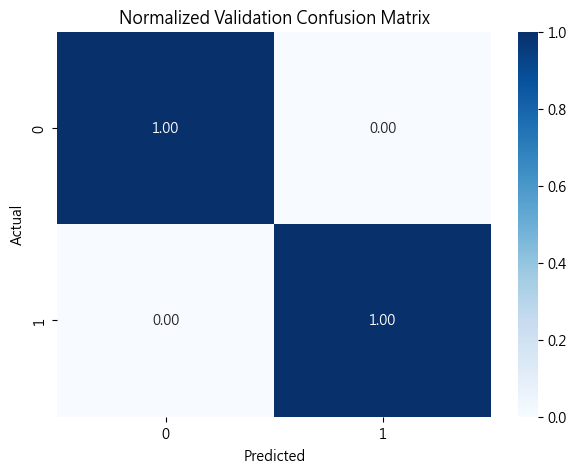

In [7]:
train_mlp_model_with_f2_score(bert_selftrain_train_data, bert_selftrain_val_data, '../Data/Model/bert_selftrain_mlp_10fold_model.pth.gz', '../Data/Model/bert_selftrain_10fold_scaler.pkl.gz')

Fold [1], Epoch [10/100], Loss: 0.0028
Fold [1], Epoch [20/100], Loss: 0.0000
Fold [1], Epoch [30/100], Loss: 0.0000
Fold [1], Epoch [40/100], Loss: 0.0000
Fold [1], Epoch [50/100], Loss: 0.0000
Fold [1], Epoch [60/100], Loss: 0.0000
Fold [1], Epoch [70/100], Loss: 0.0000
Fold [1], Epoch [80/100], Loss: 0.0000
Fold [1], Epoch [90/100], Loss: 0.0000
Fold [1], Epoch [100/100], Loss: 0.0000
Fold [2], Epoch [10/100], Loss: 0.0008
Fold [2], Epoch [20/100], Loss: 0.0000
Fold [2], Epoch [30/100], Loss: 0.0000
Fold [2], Epoch [40/100], Loss: 0.0000
Fold [2], Epoch [50/100], Loss: 0.0000
Fold [2], Epoch [60/100], Loss: 0.0000
Fold [2], Epoch [70/100], Loss: 0.0000
Fold [2], Epoch [80/100], Loss: 0.0000
Fold [2], Epoch [90/100], Loss: 0.0000
Fold [2], Epoch [100/100], Loss: 0.0000
Fold [3], Epoch [10/100], Loss: 0.0004
Fold [3], Epoch [20/100], Loss: 0.0000
Fold [3], Epoch [30/100], Loss: 0.0000
Fold [3], Epoch [40/100], Loss: 0.0000
Fold [3], Epoch [50/100], Loss: 0.0000
Fold [3], Epoch [60/100

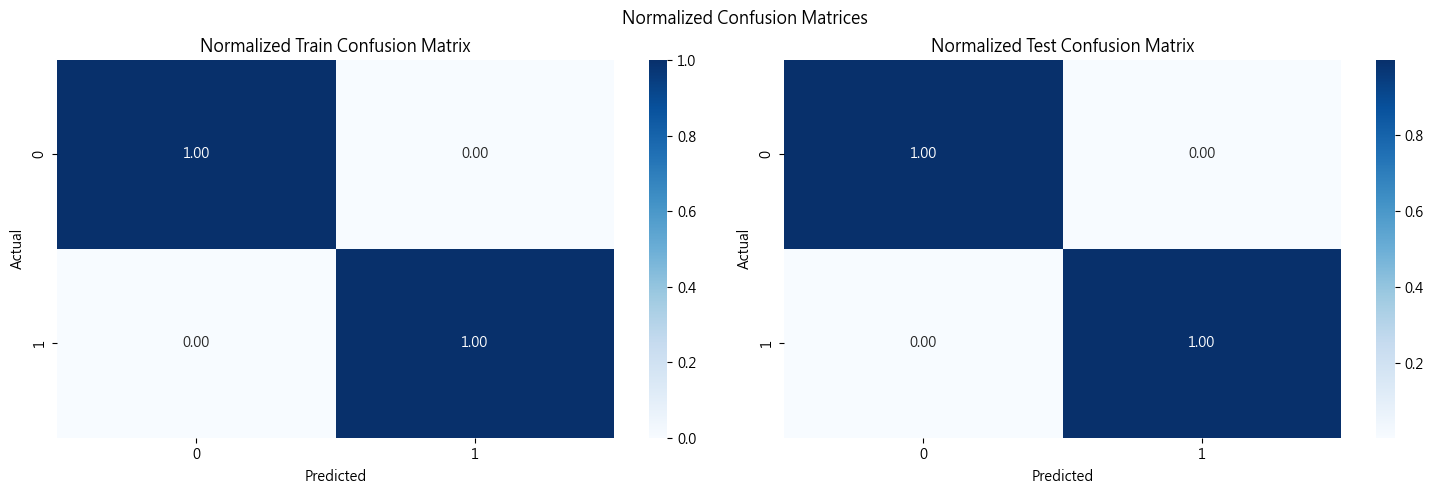

Validation F2 Score: 1.0000


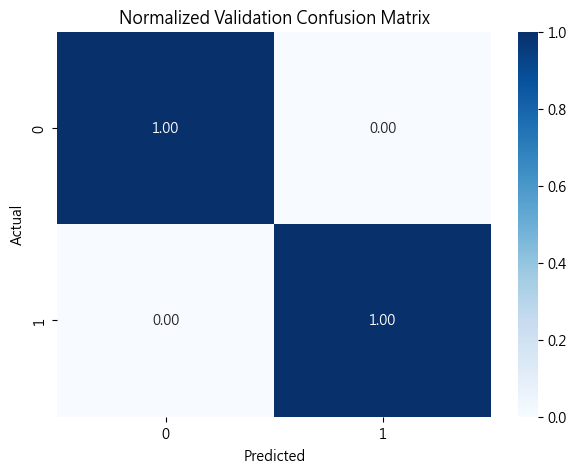

In [8]:
train_mlp_model_with_f2_score(bert_train_data, bert_val_data, '../Data/Model/bert_mlp_10fold_model.pth.gz', '../Data/Model/bert_10fold_scaler.pkl.gz')